# Sentiment Analysis

In [1]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-ma

## Import Packages and Load Data

In [2]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5, style = 'whitegrid', color_codes=True)

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, TFRobertaModel
from scipy.special import softmax
import torch

import ast
from datetime import datetime
from tqdm import tqdm
import time

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_rows', 100)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_s = pd.read_csv('/content/drive/MyDrive/Skripsi/Twitter_VADER.csv')

In [5]:
df_s.head()

,Text,Dominant_Topic,Topic_Name,VADER_Polarity,VADER_Sentiment
0,mathlievetradingsignaltime075924design closing point accord thecryptocurrency ai btc etherum bnb orc20 bch xrp usdt shib link dydx chatgpt,3,T3 Experiment AI,0.0000,Neutral
1,chatgpt cause website scrap stop get updated plan train model still also think far early ai company get sue oblivion ip theft,1,T1 Information Technology,-0.2960,Negative
2,one way education foundation could stop pay many people endless englishmajoring chatgpt start pay people system work systemsmatter,4,T4 Random Ask and Conversations,-0.4588,Negative
3,african union commission fall victim cybercrime use deep fake impersonate head moussa faki incident highlight need strong cybersecurity measure worldwide cybersecurity deepfakes africanunioncommis...,1,T1 Information Technology,0.1280,Neutral
4,chatgpt,1,T1 Information Technology,0.0000,Neutral


## roBERTa Model

In [6]:
#load the model and tokenizer

model_path = "/content/drive/MyDrive/Skripsi/roberta_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at /content/drive/MyDrive/Skripsi/roberta_sentiment_model were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# function that takes text and model to calculate the probability of each sentiment
def sentiment_analyzer(tweet,model):
    #return the output of PyTorch tensors
    encoded_tweet = tokenizer(tweet, return_tensors='pt')
    #calculate the sentiment
    output = model(**encoded_tweet)
    #returning a NumPy array containing the embeddings of scores
    scores = output[0][0].detach().numpy()
    #normalize the scores to probability
    probability = np.round(softmax(scores),3)
    #calculate the polarity by multiply each probability to its weight(Negative:-1, Neutral:0, Positive:1)
    #define weight vector
    polarity_weights = torch.tensor([-1, 0, 1])
    #construct the tensor of probability
    probability = torch.tensor(probability)
    #calculate the polartiy score
    polarity = polarity_weights*probability
    # sum the weighted probabilities along the last dimension
    polarity = polarity.sum(dim=-1)
    #Scale polarity score to range [-1, 1]
    polarity_scaled = torch.nn.Tanh()(polarity)
    return round(polarity_scaled.item(),4)

In [8]:
#df_=df_s[0:300].copy()

In [14]:
%%time
df_s['Polarity']=df_s['Text'].apply(lambda x: sentiment_analyzer(x,roberta_model))

CPU times: user 2min 18s, sys: 298 ms, total: 2min 18s
Wall time: 2min 21s


In [15]:
#as the roBERTa running will be quite long, will split the dataframe into chunks of 100 tweets each
n = 100  #chunk row size
list_df_2=[df_s[i:i+n].copy() for i in range(0,df_s.shape[0],n)]

In [16]:
len(list_df_2)

10

In [17]:
import os

# Membuat direktori roberta_temp jika belum ada
if not os.path.exists('roberta_temp'):
    os.makedirs('roberta_temp')

In [18]:
i = 0
for df in list_df_2[0:]:
    i = i+1
    df_s['ROBERTA_Polarity'] = df_s['Text'].apply(lambda x: sentiment_analyzer(x,roberta_model))
    df_s.to_csv(f'roberta_temp/chunk_{i}.csv')
df_s['ROBERTA_Sentiment'] = pd.cut(df_s['ROBERTA_Polarity'],
                                          bins = [-1, -0.25, 0.25, 1],
                                          labels = ['Negative', 'Neutral', 'Positive'])

In [19]:
#df_sentiment = pd.concat(list_df_2)

In [21]:
df_s['ROBERTA_Sentiment'] = pd.cut(df_s['ROBERTA_Polarity'],
                                          bins = [-1, -0.25, 0.25, 1],
                                          labels = ['Negative', 'Neutral', 'Positive'])

In [22]:
df_s.to_csv('/content/Twitter_Sentiment.csv', index=False)

In [23]:
df_sentiment = pd.read_csv('/content/Twitter_Sentiment.csv')

In [24]:
from transformers import pipeline

# Muat model dari direktori yang telah disimpan
sent_pipeline = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)


Some weights of the model checkpoint at /content/drive/MyDrive/Skripsi/roberta_sentiment_model were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'positive', 'score': 0.9713495969772339}]

## Comparison of VADER and roBERTa

In [26]:
#Random samples that VADER and ROBERTA models gave different sentiment output
df_sentiment[df_sentiment['ROBERTA_Sentiment']!=df_sentiment['VADER_Sentiment']].sample(100)

,Text,Dominant_Topic,Topic_Name,VADER_Polarity,VADER_Sentiment,Polarity,ROBERTA_Polarity,ROBERTA_Sentiment
258,check 135 new vote past hour submit meme get rank chatgptmemes chatgpt ai ai meme funny chatgpt,1,T1 Information Technology,0.4404,Positive,0.0778,0.0778,Neutral
108,openai prepare boost chatgpt different model know gpt4 upcoming arrakis model would allow company run chatbot less expensively,1,T1 Information Technology,0.5574,Positive,0.2298,0.2298,Neutral
812,publish new post email subject line optimization free chatgpt prompt,3,T3 Experiment AI,0.7096,Positive,0.0500,0.0500,Neutral
975,embrace challenge turn powerful lesson others chatgpt interpretation allow mess become message,2,T2 Education and Foundations,0.5859,Positive,-0.0190,-0.0190,Neutral
956,sometimes copy paste tweet chatgpt ask explain consistent clear way write thing disable rotten subhuman brain easily understand bit like wheelchair ik ew,4,T4 Random Ask and Conversations,0.4939,Positive,-0.6696,-0.6696,Negative
67,think biden use chatgpt lol someone else type,1,T1 Information Technology,0.4215,Positive,-0.1342,-0.1342,Neutral
81,bout ask chatgpt design cheatsheet,4,T4 Random Ask and Conversations,0.0000,Neutral,-0.3004,-0.3004,Negative
174,whoever write marlas close statement need tell there new version chatgpt,1,T1 Information Technology,0.0000,Neutral,-0.4325,-0.4325,Negative
601,chatgpt suppyiny game niggas best watch ya girl im fina get street,1,T1 Information Technology,0.4215,Positive,-0.1916,-0.1916,Neutral
94,im play around side project note want work essay give first round prosification chatgpt see go enjoy edit much primary draft work might try thing,1,T1 Information Technology,0.7096,Positive,0.2108,0.2108,Neutral


<ipython-input-27-e4e9e3f1921b>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_sentiment['VADER_Polarity'],shade=True, legend='Vader', alpha=0.8)
<ipython-input-27-e4e9e3f1921b>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df_sentiment['ROBERTA_Polarity'], shade=True, legend='roBERTa', alpha=0.5)


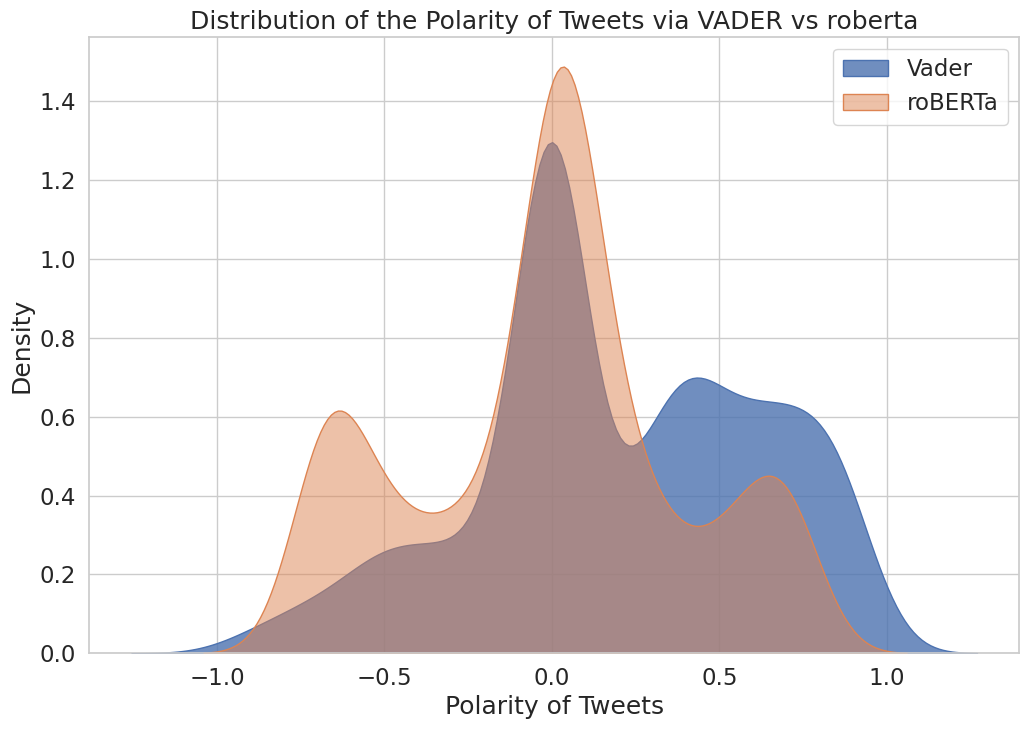

In [27]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.kdeplot(df_sentiment['VADER_Polarity'],shade=True, legend='Vader', alpha=0.8)
ax = sns.kdeplot(df_sentiment['ROBERTA_Polarity'], shade=True, legend='roBERTa', alpha=0.5)
ax.set_xlabel('Polarity of Tweets')
ax.set_title('Distribution of the Polarity of Tweets via VADER vs roberta')
plt.legend(['Vader','roBERTa'])
plt.show()

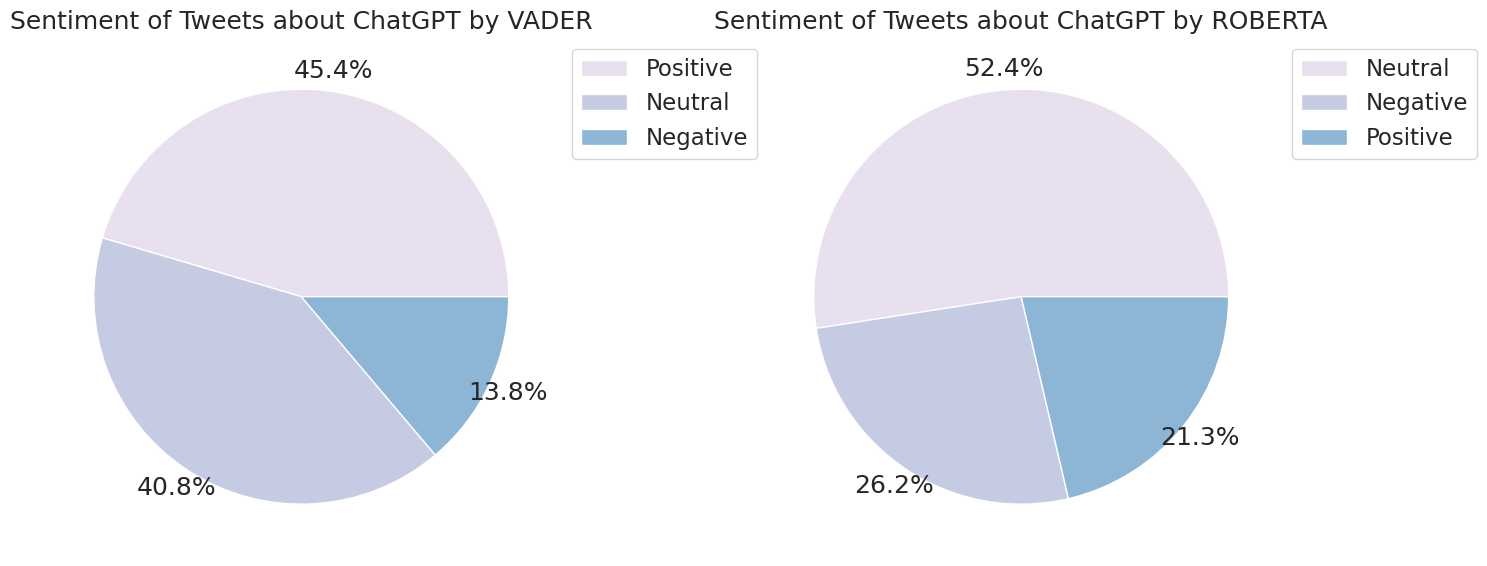

In [28]:
sns.set_palette('PuBuGn')
fig,ax=plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
pie_1 = df_sentiment['VADER_Sentiment'].value_counts()
plt.pie(pie_1, autopct="%.1f%%", pctdistance=1.1)
plt.legend(labels = pie_1.index,
          bbox_to_anchor=[1,1])
plt.title('Sentiment of Tweets about ChatGPT by VADER')

plt.subplot(1,2,2)
pie_2 = df_sentiment['ROBERTA_Sentiment'].value_counts()
plt.pie(pie_2, autopct="%.1f%%", pctdistance=1.1)
plt.legend(labels = pie_2.index,
          bbox_to_anchor=[1,1])
plt.title('Sentiment of Tweets about ChatGPT by ROBERTA')

plt.tight_layout()
plt.show()

# EDA_Sentiment of Tweets

The EDA of the sentiment of tweets is conducted via the roBERTA sentiment prediction.

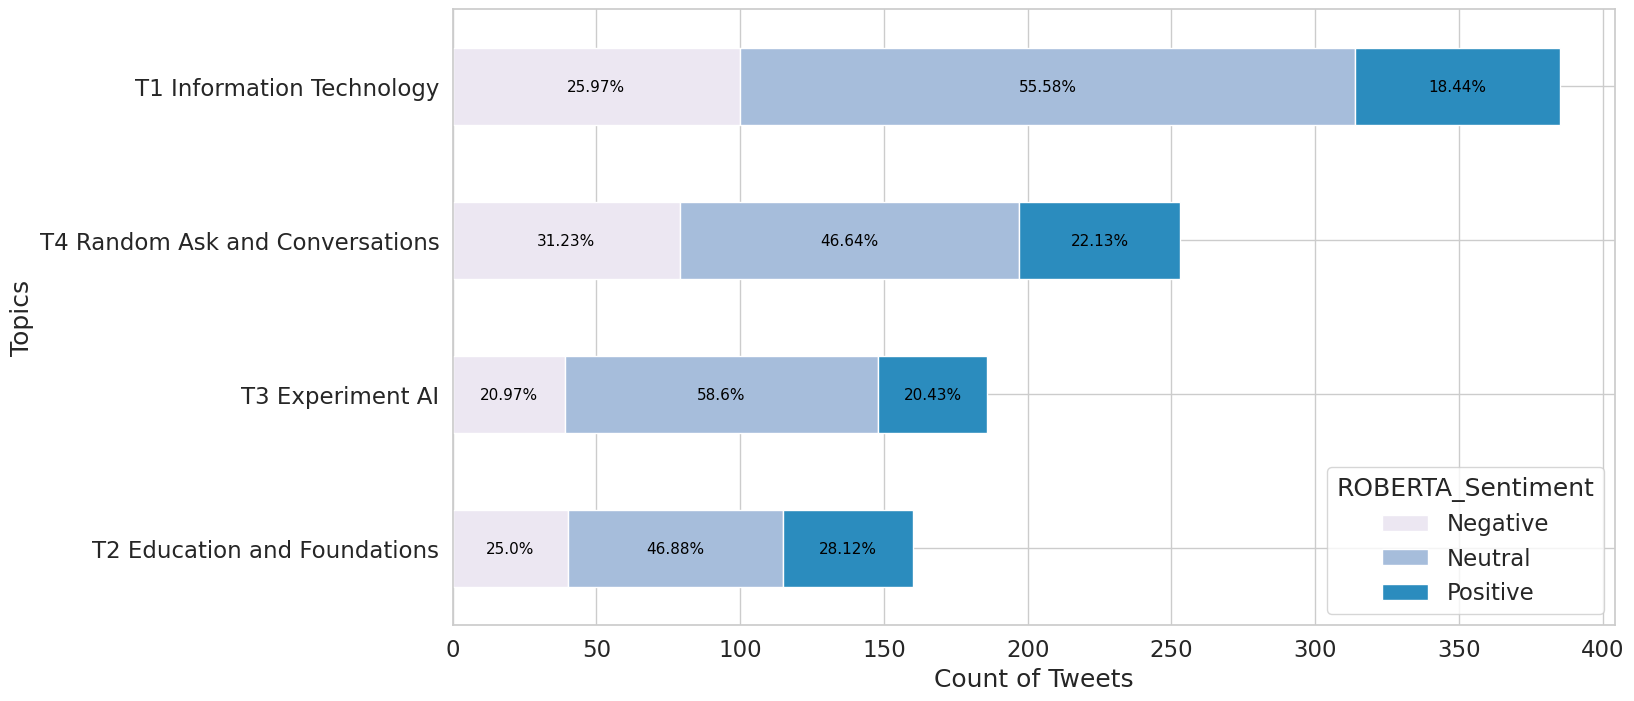

In [29]:
# Sentiment of each topic

topic_sen = df_sentiment.groupby('Topic_Name')['ROBERTA_Sentiment'].value_counts().unstack().reset_index()
#sort by the popularity of the topics (total count)
topic_sen['Total']=topic_sen['Negative']+topic_sen['Neutral']+topic_sen['Positive']
topic_sen = topic_sen.sort_values('Total')
topic_sen=topic_sen.drop(columns='Total')
topic_sen = topic_sen.set_index('Topic_Name')

ax=topic_sen.plot(kind='barh',stacked='True', color=['#ece7f2', '#a6bddb', '#2b8cbe'], figsize=(15,8))
#get the percentage of each sentiment in specific topic
percentages = topic_sen.div(topic_sen.sum(axis=1), axis=0)
percentages = percentages.reset_index().melt('Topic_Name', var_name='Sentiment', value_name='Percentage')
#label the percentage of each sentiment
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x()+patch.get_width()/2,
            patch.get_y()+0.25,
            f'{round(percentages.loc[i,"Percentage"]*100,2)}%',
            ha='center', va='center',
            color='black', fontsize=11)
ax.set_xlabel('Count of Tweets')
ax.set_ylabel('Topics')
plt.show()

In [31]:
vader_counts = df_sentiment['VADER_Sentiment'].value_counts()
roberta_counts = df_sentiment['ROBERTA_Sentiment'].value_counts()


In [32]:
print("VADER Sentiment Counts:")
print(vader_counts)
print("\nRoberta Sentiment Counts:")
print(roberta_counts)


VADER Sentiment Counts:
VADER_Sentiment
Positive    447
Neutral     401
Negative    136
Name: count, dtype: int64

Roberta Sentiment Counts:
ROBERTA_Sentiment
Neutral     516
Negative    258
Positive    210
Name: count, dtype: int64
